In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Optimizer():
    def __init__(self, max_step):
        self.param_history = []
        self.func_history = []
        self.max_step = max_step
    
    def clear(self):
        self.param_history = []
        self.func_history = []

    def GD(self, function, w, others, r, lr=1):
        # GD : gradient descent
        # function : Function
        # r : stop condition
        self.clear()
        tmp = np.copy(w)
        self.param_history.append(tmp)
        self.func_history.append(function.f(tmp, others))
        count = 0
        while count < self.max_step:
            grads = function.grad(tmp, others)
            tmp = tmp-lr*grads
            self.param_history.append(tmp)
            self.func_history.append(function.f(tmp, others))
            if np.linalg.norm(grads, ord=2) < r:
                break
            count +=1
        
        return tmp
                

    def Newton(self, function, w, others, r):
        # function : Function
        # r : stop condition
        self.clear()
        tmp = np.copy(w).flatten()
        self.param_history.append(tmp.reshape(w.shape))
        self.func_history.append(function.f(tmp.reshape(w.shape), others))
        count = 0
        while count < self.max_step:
            grads = function.grad(tmp.reshape(w.shape), others).flatten()
            hessians = function.hessian(tmp.reshape(w.shape), others)
            tmp = tmp-np.dot(np.linalg.pinv(hessians), grads)
            self.param_history.append(tmp.reshape(w.shape))
            self.func_history.append(function.f(tmp.reshape(w.shape), others))
            if np.linalg.norm(grads, ord=2) < r:
                break
            count +=1
        return tmp.reshape(w.shape)

In [3]:
class Function():
    # x : numpy.ndarray
    h = 1e-4
    def __init__(self):
        return

    def f(self, w, others):
        # It must be overridden
        # w : need grad
        # others : do not need grad
        return w

    def grad(self, w, others):
        # may be overridden if f' can be solved analytically
        tmp = 0
        grads = np.zeros_like(w, dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            fx1 = self.f(w, others)
            w[i] = tmp + self.h
            fx2 = self.f(w, others)
            grads[i] = (fx2-fx1)/(2*self.h)
            w[i] = tmp

        return grads

    def hessian(self, w, others):
        tmp = 0
        hessians = np.zeros([w.size, w.size], dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            grads1 = self.grad(w, others)
            w[i] = tmp + self.h
            grads2 = self.grad(w, others)
            hessians[:, i] = (grads2-grads1)/(2*self.h)
            w[i] = tmp

        return hessians

In [4]:
class P1F(Function):
    def __init__(self, lamb=0.01):
        self.lamb = lamb
    
    def f(self, w, others):
        # others : [[list of x], [list of y]]
        # list of x : np.array(np.ndarray, np.ndarray, ...)
        # list of y : [int, int, int, int, ...]
        # x is int
        res = 0
        xs = others[0]
        ys = others[1]
        for x, y in zip(xs, ys):
            res += np.log(1+np.exp(-y*np.dot(w, x)))
        
        res += self.lamb*np.dot(w, w)
        return res

    # def grad(self, w, others):
    #     xs = others[0]
    #     ys = others[1]
    #     grads = np.zeros_like(w, dtype=float)
    #     for x, y in zip(xs, ys):
    #         tmp = (np.exp(-y*np.dot(w, x))*(-y*x))/(1+np.exp(-y*np.dot(w, x)))
    #         grads += tmp

    #     grads += 2*self.lamb*w

    #     return grads

In [31]:
def plot_result(w, history, title):
    fig,ax = plt.subplots()
    ax.plot(list(range(len(history[1]))), history[1])
    ax.set_title(title)
    plt.show()

def plot_performance(ws, histories, title, opt, sizes, labels):
    fig,ax = plt.subplots(figsize=sizes)
    ax.plot(list(range(len(histories[0][1]))), histories[0][1]-opt, label=labels[0])
    ax.plot(list(range(len(histories[1][1]))), histories[1][1]-opt, label=labels[1])
    ax.set_title(title)
    #ax[i].set_ylim(bottom=0)
    ax.set_yscale('log')
    ax.legend()
    plt.show()

def binary_acc(xs, ys, w):
    acc_count = 0
    for x, y in zip(xs, ys):
        if np.dot(w, x) > 0:
            pred = 1
        else:
            pred = -1
        
        if pred==y:
            acc_count +=1

    return acc_count / len(ys)

def multi_acc(xs, ys, w):
    acc_count = 0
    for x, y in zip(xs, ys):
        pred = np.dot(w, x).argmax()
        if pred == y:
            acc_count +=1

    return acc_count / len(ys)

    

In [6]:
# making dataset IV
np.random.seed(0)
n = 200
#[[x0], [x1], [x2], ...]
x = 3*(np.random.rand(n,4)-0.5)
y = (2*x[:, 0] - x[:, 1] + 0.5 + 0.5*np.random.randn(n)) > 0
y = 2*y-1

In [7]:
np.random.seed(1)
w = np.random.rand(4)
p1f = P1F()
optimizer = Optimizer(1024)

In [8]:
# 1
w_opt_g = optimizer.GD(function=p1f, w=w, others=[x, y], r=0.01, lr=1e-3)
print(w_opt_g)
history_g = [optimizer.param_history, optimizer.func_history]

[ 4.0746031  -1.87064813 -0.16980306 -0.27885571]


In [10]:
# 2
w_opt_n = optimizer.Newton(function=p1f, w=w, others=[x, y], r=0.01)
print(w_opt_n)
history_n = [optimizer.param_history, optimizer.func_history]

[ 4.25888853 -1.97731083 -0.17749302 -0.28179864]


In [11]:
print('accuracy')
print('before training : ', binary_acc(x, y, w))
print('GD : ', binary_acc(x, y, w_opt_g))
print('Newton : ', binary_acc(x, y, w_opt_n))

accuracy
before training :  0.515
GD :  0.855
Newton :  0.855


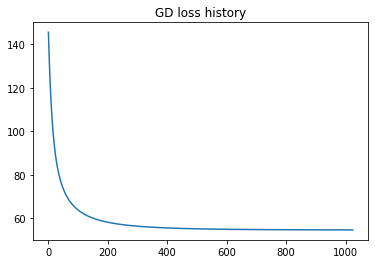

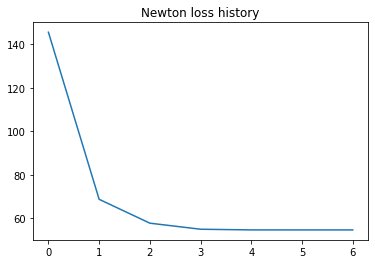

In [12]:
plot_result(w_opt_g, history_g, 'GD loss history')
plot_result(w_opt_n, history_n, 'Newton loss history')

In [13]:
f_g = p1f.f(w_opt_g, [x,y])
f_n = p1f.f(w_opt_n, [x,y])
print('GD     : ', f_g)
print('Newton : ', f_n)

GD     :  54.73632190012506
Newton :  54.68890021609997


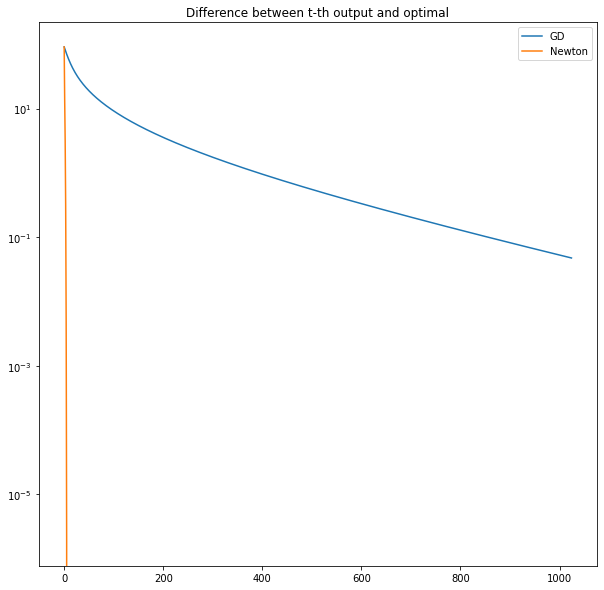

In [36]:
#3
ws = [w_opt_g, w_opt_n]
histories = [history_g, history_n]
title = 'Difference between t-th output and optimal'
sizes = [10, 10]
plot_performance(ws, histories, title, f_n, sizes, ['GD', 'Newton'])

In [15]:
# making dataset V
n = 200
np.random.seed(3)
x = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y = np.argmax(np.dot(np.hstack([x[:,:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

In [16]:
def softmax(a):
    # a : numpy.ndarray
    # m : float
    m = a.max()
    return np.exp(a-m)/np.exp(a-m).sum()

def to_one_hot(arrays, num_class):
    res = np.zeros([len(arrays), num_class])
    for i in range(len(arrays)):
        res[i][arrays[i]] = 1
    
    return res

class P1FMulti(Function):
    eps = 1e-4
    def __init__(self):
        return
    
    def f(self, w, others):
        # average softmax cross entropy
        # w : [[param0], [param1], ..., [paramn]]
        # ys.size : dataset size
        xs = others[0]
        ys = others[1]
        res = 0
        for i in range(ys.size):
            loss = softmax(np.dot(w, xs[i]))
            res -= np.log(loss[y[i]]+self.eps)
        
        res /= ys.size
        return res                

    def grad_oneparam(self, w, others, i):
        tmp = 0
        grads = np.zeros_like(w[i])
        for j in range(w[i].size):
            tmp = w[i][j]
            w[i][j] = tmp - self.h
            fx1 = self.f(w, others)
            w[i][j] = tmp + self.h
            fx2 = self.f(w, others)
            grads[j] = (fx2-fx1)/(2*self.h)
            w[i][j] = tmp
        return grads

    def grad(self, w, others):
        tmp = 0
        grads = np.zeros_like(w, dtype=float)
        for i in range(w.shape[0]):
            grads[i] = self.grad_oneparam(w, others, i)
        return grads

    def hessian(self, w, others):
        # res
        M = w.shape[1]
        K = w.shape[0]
        hessians = np.zeros([M*K, M*K])
        for i in range(K):
            for j in range(K):
                tmp = 0
                Hij = np.zeros([M, M])
                for k in range(w[j].size):
                    tmp = w[j][k]
                    w[j][k] = tmp - self.h
                    grads1 = self.grad_oneparam(w, others, i)
                    w[j][k] = tmp + self.h
                    grads2 = self.grad_oneparam(w, others, i)
                    Hij[:, k] = (grads2-grads1)/(2*self.h)
                    w[j][k] = tmp
                hessians[i*M:(i+1)*M, j*M:(j+1)*M] = Hij
        return hessians

In [17]:
p1fm = P1FMulti()

In [18]:
K = 3
M = 4
np.random.seed(3)
wm = np.random.rand(K,M)

In [19]:
w_opt_mg = optimizer.GD(function=p1fm, w=wm, others=[x, y], r=0.01, lr=1e-2)
print(w_opt_mg)
history_mg = [optimizer.param_history, optimizer.func_history]

[[ 0.94811631 -0.12546635  0.15235385  0.47076431]
 [-0.87557532  0.82692313  0.1155093   0.45911034]
 [ 1.42267107  1.34379397  0.17850311  0.24502905]]


In [20]:
w_opt_mn = optimizer.Newton(function=p1fm, w=wm, others=[x, y], r=0.01)
print(w_opt_mn)
history_mn = [optimizer.param_history, optimizer.func_history]

[[ 1.32641249 -5.87727532  1.69481808 -3.28953626]
 [-2.23168893 -4.43905727  1.82792393 -3.03123833]
 [ 2.66117111 -2.98010563  2.03075325 -3.55077835]]


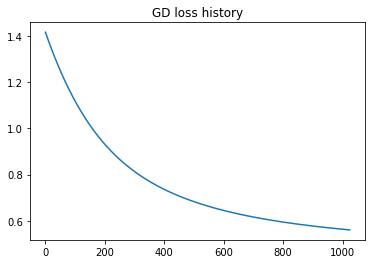

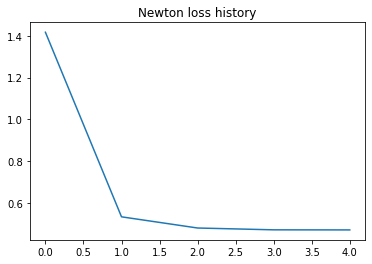

In [21]:
plot_result(w_opt_mg, history_mg, 'GD loss history')
plot_result(w_opt_mn, history_mn, 'Newton loss history')

In [22]:
print('accuracy')
print('before training : ', multi_acc(x, y, wm))
print('GD : ', multi_acc(x, y, w_opt_mg))
print('Newton : ', multi_acc(x, y, w_opt_mn))

accuracy
before training :  0.125
GD :  0.81
Newton :  0.83


In [23]:
f_mg = p1fm.f(w_opt_mg, [x,y])
f_mn = p1fm.f(w_opt_mn, [x,y])
print('GD     : ', f_mg)
print('Newton : ', f_mn)

GD     :  0.5601573208214744
Newton :  0.4703922894881937


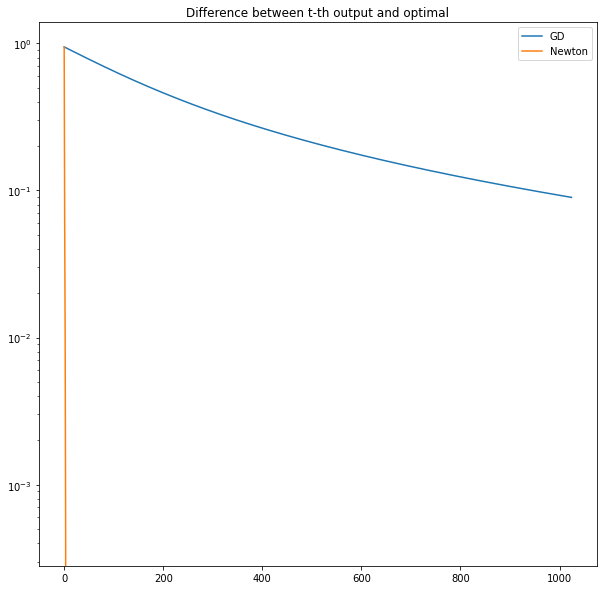

In [35]:
wms = [w_opt_mg, w_opt_mn]
histories = [history_mg, history_mn]
titles = 'Difference between t-th output and optimal'
sizes = [10, 10]
plot_performance(wms, histories, title, f_mn, sizes, ['GD', 'Newton'])